-

# Diversification Product Simulation with the SZHW Model

This simulation combines a stochastic stock price, a stochastic volatility process, and a stochastic interest rate process (following the Hull–White model) into a diversification product. The product’s payoff depends on both the performance of the stock and the performance of a zero-coupon bond (ZCB).

---

## 1. Hull–White (HW) Model Components

The HW model models the short rate \(r(t)\) using the stochastic differential equation (SDE):

- $$ dr(t) = \lambda \left(\theta(t) - r(t)\right) dt + \eta\, dW_r(t) ,$$

where  
- \(\lambda\) is the mean reversion speed,  
- \(\theta(t)\) is a time-dependent drift designed to fit the initial yield curve, and  
- \(\eta\) is the volatility parameter for the interest rate.

### 1.1. Calculating \(\theta(t)\)

The function `HW_theta(lambd,eta,P0T)` approximates \(\theta(t)\) by first calculating the instantaneous forward rate using numerical differentiation. For a small time-step \(dt\), the forward rate is approximated as

- $$ f(0,t) \approx -\frac{\ln(P_{0T}(t+dt)) - \ln(P_{0T}(t-dt))}{2\, dt} .$$

Then, \(\theta(t)\) is calculated with the formula

- $$ \theta(t) = \frac{1}{\lambda}\,\frac{df(0,t)}{dt} + f(0,t) + \frac{\eta^2}{2\lambda^2}\left(1 - e^{-2\lambda t}\right) .$$

This function returns a callable function for \(\theta(t)\) which is used in further calculations.

### 1.2. Zero-Coupon Bond Pricing in the HW Framework

A ZCB price from time \(T_1\) to \(T_2\) under the HW model is given by

- $$ P(T_1,T_2) = \exp\left(A(T_1,T_2) + B(T_1,T_2) \, r(T_1)\right) .$$

The functions `HW_B` and `HW_A` compute the following:

- $$ B(T_1,T_2) = \frac{1}{\lambda}\left(e^{-\lambda (T_2-T_1)} - 1\right) ,$$

- $$ A(T_1,T_2) = \lambda \int_0^{\tau} \theta(T_2 - z) B_r(z)\,dz + \frac{\eta^2}{4\lambda^3}\left(e^{-2\lambda \tau}\left(4e^{\lambda \tau} - 1\right) - 3\right) + \frac{\eta^2\,\tau}{2\lambda^2} ,$$

with \(\tau = T_2 - T_1\) and  
$$ B_r(z) = \frac{1}{\lambda}\left(e^{-\lambda z} - 1\right) .$$

These functions allow us to compute the ZCB price needed for the diversification product.

---

## 2. SZHW Model and Monte Carlo Simulation

The SZHW model blends a stochastic volatility model (similar to the Schobel–Zhu or Heston model) with the HW model for interest rates.

### 2.1. Correlated Brownian Motions

In the simulation, three Brownian motions are used:
- \(W_x\) for the stock (or log-stock process),
- \(W_\sigma\) for the volatility process, and  
- \(W_r\) for the interest rate process.

They are generated with a specified correlation matrix:
- $$ \textbf{cov} = \begin{pmatrix} 1 & \rho_{x\sigma} & \rho_{xr} \\[2mm] \rho_{x\sigma} & 1 & \rho_{\sigma r} \\[2mm] \rho_{xr} & \rho_{\sigma r} & 1 \end{pmatrix} .$$

The parameters `Rxsigma`, `Rxr`, and `Rsigmar` in the code represent these correlations. This multivariate normal sampling guarantees that the simulated random increments respect the desired dependency structure.

### 2.2. Euler Discretization of the SDEs

For each time step \(\Delta t\), the following updates are made:

1. **Short Rate \(r(t)\):**

   - $$ r(t+\Delta t) = r(t) + \lambda\left(\theta(t)-r(t)\right)\Delta t + \eta\,\Delta W_r(t) ,$$

2. **Discount Factor \(M(t)\):**

   - $$ M(t+\Delta t) = M(t) \times \exp\left(0.5\left(r(t+\Delta t) + r(t)\right) \Delta t\right) ,$$

   which approximates the continuous discounting:
   - $$ M(t) = \exp\left(\int_0^t r(s)\,ds\right) .$$

3. **Volatility Process \(\Sigma(t)\):**

   - $$ \Sigma(t+\Delta t) = \Sigma(t) + \kappa\left(\bar{\sigma} - \Sigma(t)\right) \Delta t + \gamma\,\Delta W_\sigma(t) ,$$

   where \(\kappa\) is the mean reversion speed for volatility and \(\bar{\sigma}\) is its long-term average.

4. **Log-Stock Process \(X(t)\):**

   - $$ X(t+\Delta t) = X(t) + \left(r(t) - \frac{1}{2}\Sigma(t)^2\right)\Delta t + \Sigma(t)\,\Delta W_x(t) ,$$

   with the stock price given by \(S(t) = \exp(X(t))\).

At each time step, a moment-matching adjustment is applied to \(X(t)\) to enforce
- $$ \mathbb{E}\left[\frac{S(T)}{M(T)}\right] = S_0 ,$$
which ensures consistency with the risk-neutral pricing measure.

---

## 3. Diversification Product Payoff

The diversification product combines exposure to the stock and the bond. Its payoff at time \(T\) is defined by:

- $$ \text{payoff} = \omega \frac{S_T}{S_0} + (1-\omega) \frac{P_{T,T_1}}{P_{0,T_1}} ,$$

where:
- \(S_T\) is the stock price at time \(T\),
- \(S_0\) is the initial stock price,
- \(P_{T,T_1}\) is the price of the ZCB at time \(T\) maturing at \(T_1\),
- \(P_{0,T_1}\) is the current (time 0) bond price,
- \(\omega\) is a weight (the "waiting factor") which can vary over a range.

This formulation represents a linear combination (or diversification) where a fraction \(\omega\) is invested in the stock and \(1-\omega\) in the bond. The idea is to capture the benefits of both market exposures. A higher stock weight means more sensitivity to the equity market, while a higher bond weight brings in the stability of the fixed income component.

After computing the raw payoff, the product value is computed by discounting the payoff by the stochastic discount factor \(M_T\) and taking the expected (Monte Carlo average) value:

- $$ \text{Product Price} = \mathbb{E}\left[\frac{1}{M_T}\max\left\{\text{payoff},\,0\right\}\right] .$$

The use of the maximum function indicates a call-like option feature embedded in the product, protecting against negative returns.

---

## 4. Putting It All Together in the Code

The function `mainCalculation()` integrates all these components:

1. **Parameter Settings:**  
   The HW parameters (\(\lambda\) and \(\eta\)), the stock price \(S_0\), product maturities \(T\) and \(T_1\), and the SZHW model parameters (including \(\sigma_0\), \(\bar{\sigma}\), \(\kappa\), \(\gamma\), and the correlation parameters) are specified.

2. **Zero-Coupon Bond Curve:**  
   The ZCB curve is defined as  
   - $$ P_{0T}(T) = \exp(-0.033\, T) .$$

3. **Monte Carlo Simulation:**  
   The function calls `GeneratePathsSZHWEuler()` to generate multiple simulated paths for \(S(t)\), \(\Sigma(t)\), and \(r(t)\). The final values \(S_T\), \(r_T\), and \(M_T\) are extracted at time \(T\).

4. **Diversification Payoff Calculation:**  
   For each waiting factor value \(\omega\) (from the vector \(\omega_V\)), the function `DiversifcationPayoff()` computes:
   - The bond price at time \(T\) for maturity \(T_1\), computed as  
     $$ P_{T,T_1} = HW\_ZCB(\lambda,\eta,P_{0T}, T, T_1, r_T) ,$$
   - The relative bond price is then  
     $$ \frac{P_{T,T_1}}{P_{0,T_1}} ,$$
   - And the diversification payoff as  
     $$ \omega\, \frac{S_T}{S_0} + (1-\omega)\, \frac{P_{T,T_1}}{P_{0,T_1}} .$$

   This payoff is then discounted by dividing by \(M_T\) and averaged over all Monte Carlo paths to produce the final product price.

5. **Visualization:**  
   Two plots are generated:
   - One shows the absolute diversification product price as a function of \(\omega\).
   - A second plot shows the product value relative to a reference case (often the case where \(\rho_{xr} = 0\)), highlighting the impact of correlation effects.

---

## 5. Additional Theory on the Diversification Product

The diversification product is intended to offer a balanced exposure between risky equity and relatively stable fixed income. Such products are designed to lower overall portfolio volatility through diversification. Key points include:

- **Risk Reduction:**  
  By combining a volatile asset with a stable bond, the overall volatility of returns can be reduced, which is particularly useful in risk-averse investment strategies.

- **Return Enhancement:**  
  The allocation parameter \(\omega\) allows investors to adjust the balance between potential higher equity returns and the safety of bonds. In practice, an investor might choose a particular \(\omega\) based on their risk tolerance or market expectations.

- **Dynamic Hedging:**  
  The product’s embedded structure can require dynamic hedging. The use of Monte Carlo simulation in this code aims to capture the full joint dynamics (including correlation effects) of equity, volatility, and interest rates. This ensures that the pricing accounts for all sources of risk.

- **Pricing Under the Risk-Neutral Measure:**  
  The Monte Carlo expectation  
  $$ \mathbb{E}\left[\frac{1}{M_T}\max\left\{\,\text{payoff},0\right\}\right] $$
  is taken under the risk-neutral measure. The discount factor \(M_T\) plays a crucial role in adjusting future payoffs to present value terms, ensuring consistency with market prices.

---

## Conclusion

To summarize:

- **HW Model:**  
  Models the evolution of interest rates with time-dependent drift \( \theta(t) \) and yields bond prices using the functions \( A(T_1,T_2) \) and \( B(T_1,T_2) \).

- **SZHW Model & Monte Carlo Paths:**  
  The stock price, its stochastic volatility, and the short rate are simulated using Euler discretization while respecting a given correlation matrix. Moment matching ensures risk-neutral pricing.

- **Diversification Product:**  
  Combines the relative performance of the stock and bond components using a weight \( \omega \). The payoff is discounted and averaged to provide a fair price.

This detailed explanation with inline LaTeX formulas should be well-suited for inclusion in your Jupyter Notebook. Adjust or expand any section as needed for further clarity or additional theoretical discussion.

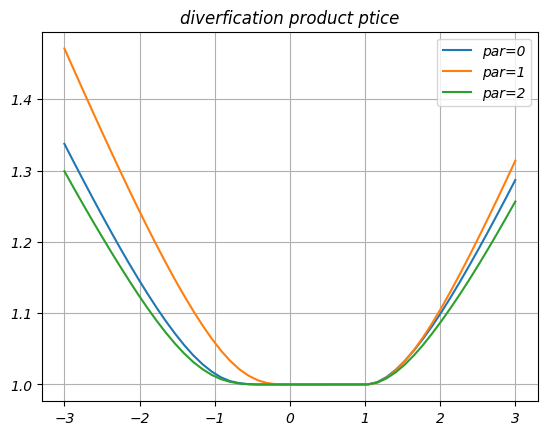

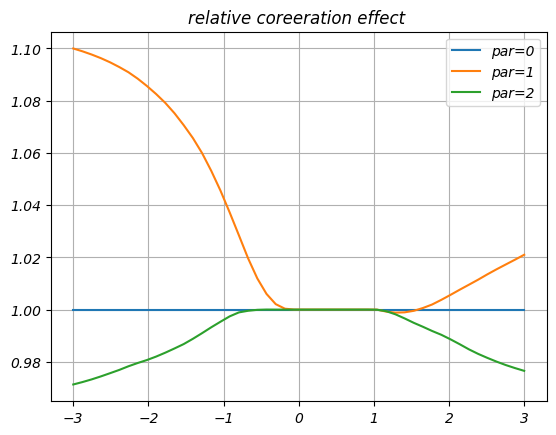

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import enum 

# set i= imaginary number
i   = 1j

# time-step needed for differentiation
dt = 0.0001

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

def HW_theta(lambd,eta,P0T):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    return theta

def HW_A(lambd,eta,P0T,T1,T2):
    tau = T2-T1
    zGrid = np.linspace(0.0,tau,250)
    B_r = lambda tau: 1.0/lambd * (np.exp(-lambd *tau)-1.0)
    theta = HW_theta(lambd,eta,P0T)    
    temp1 = lambd * integrate.trapz(theta(T2-zGrid)*B_r(zGrid),zGrid)
    
    temp2 = eta*eta/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) -3.0) + eta*eta*tau/(2.0*lambd*lambd)
    
    return temp1 + temp2

def HW_B(lambd,eta,T1,T2):
    return 1.0/lambd *(np.exp(-lambd*(T2-T1))-1.0)

def HW_ZCB(lambd,eta,P0T,T1,T2,rT1):
    B_r = HW_B(lambd,eta,T1,T2)
    A_r = HW_A(lambd,eta,P0T,T1,T2)
    return np.exp(A_r + B_r *rT1)

def EUOptionPriceFromMCPathsGeneralizedStochIR(CP,S,K,T,M):
    # S is a vector of Monte Carlo samples at T
    result = np.zeros([len(K),1])
    if CP == OptionType.CALL:
        for (idx,k) in enumerate(K):
            result[idx] = np.mean(1.0/M*np.maximum(S-k,0.0))
    elif CP == OptionType.PUT:
        for (idx,k) in enumerate(K):
            result[idx] = np.mean(1.0/M*np.maximum(k-S,0.0))
    return result

def GeneratePathsSZHWEuler(NoOfPaths,NoOfSteps,P0T,T,S0,sigma0,sigmabar,kappa,gamma,lambd,eta,Rxsigma,Rxr,Rsigmar):    
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))      
    
    # Empty containers for Brownian motion
    Wx = np.zeros([NoOfPaths, NoOfSteps+1])
    Wsigma = np.zeros([NoOfPaths, NoOfSteps+1])
    Wr = np.zeros([NoOfPaths, NoOfSteps+1])
    
    Sigma = np.zeros([NoOfPaths, NoOfSteps+1])
    X     = np.zeros([NoOfPaths, NoOfSteps+1])
    R     = np.zeros([NoOfPaths, NoOfSteps+1])
    M_t   = np.ones([NoOfPaths,NoOfSteps+1])
    R[:,0]     = r0 
    Sigma[:,0] = sigma0
    X[:,0]     = np.log(S0)
    
    dt = T / float(NoOfSteps)    
    cov = np.array([[1.0, Rxsigma,Rxr],[Rxsigma,1.0,Rsigmar], [Rxr,Rsigmar,1.0]])
      
    time = np.zeros([NoOfSteps+1])    

    for i in range(0,NoOfSteps):
        Z = np.random.multivariate_normal([.0,.0,.0],cov,NoOfPaths)
        if NoOfPaths > 1:
            Z[:,0] = (Z[:,0] - np.mean(Z[:,0])) / np.std(Z[:,0])
            Z[:,1] = (Z[:,1] - np.mean(Z[:,1])) / np.std(Z[:,1])
            Z[:,2] = (Z[:,2] - np.mean(Z[:,2])) / np.std(Z[:,2])
            
        Wx[:,i+1]     = Wx[:,i]     + np.power(dt, 0.5)*Z[:,0]
        Wsigma[:,i+1] = Wsigma[:,i] + np.power(dt, 0.5)*Z[:,1]
        Wr[:,i+1]     = Wr[:,i]     + np.power(dt, 0.5)*Z[:,2]

        # Euler discretization
        R[:,i+1]     = R[:,i] + lambd*(theta(time[i]) - R[:,i])*dt + eta * (Wr[:,i+1]-Wr[:,i])
        M_t[:,i+1]   = M_t[:,i] * np.exp(0.5*(R[:,i+1] + R[:,i])*dt)
        Sigma[:,i+1] = Sigma[:,i] + kappa*(sigmabar - Sigma[:,i])*dt + gamma* (Wsigma[:,i+1]-Wsigma[:,i])                        
        X[:,i+1]     = X[:,i] + (R[:,i] - 0.5*Sigma[:,i]**2.0)*dt + Sigma[:,i] * (Wx[:,i+1]-Wx[:,i])                        
        time[i+1] = time[i] +dt
        
        # Moment matching component, i.e.: ensure that E(S(T)/M(T))= S0
        a = S0 / np.mean(np.exp(X[:,i+1])/M_t[:,i+1])
        X[:,i+1] = X[:,i+1] + np.log(a)
        
    paths = {"time":time,"S":np.exp(X),"M_t":M_t,"R":R}
    return paths

def DiversifcationPayoff(P0T,S_T,S0,r_T,M_T,T,T1,lambd,eta,omegaV):
    P_T_T1= HW_ZCB(lambd,eta,P0T,T,T1,r_T)
    P_0_T1= P0T(T1)
    
    value =np.zeros(omegaV.size)
    for (idx,omega) in enumerate(omegaV):
        payoff = omega * S_T/S0 + (1.0-omega) * P_T_T1/P_0_T1
        value[idx] = np.mean(1/M_T*np.maximum(payoff,0.0))
    return value

def mainCalculation():
    # HW model settings
    lambd = 1.12
    eta   = 0.02
    S0    = 100.0
    
    # Fixed mean reversion parameter
    kappa   = 0.5
    # Diversification product
    T  = 9.0
    T1 = 10.0
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.033*T) 
     
    # Range of the waiting factor
    omegaV=  np.linspace(-3.0,3.0,50)
    # Monte Carlo setting
    NoOfPaths =5000
    NoOfSteps = int(100*T)
    
    # The SZHW model parameters
    # The parameters can be obtained by running the calibration of the SZHW model and with
    # varying the correlation rhoxr.
  
    parameters=[{"Rxr":0.0,"sigmabar":0.167,"gamma":0.2,"Rxsigma":-0.850,"Rrsigma":-0.008,"kappa":0.5,"sigma0":0.035},
                {"Rxr":-0.7,"sigmabar":0.137,"gamma":0.236,"Rxsigma":-0.381,"Rrsigma":-0.339,"kappa":0.5,"sigma0":0.084},
                {"Rxr":0.7,"sigmabar":0.102,"gamma":0.211,"Rxsigma":-0.850,"Rrsigma":-0.340,"kappa":0.5,"sigma0":0.01}]
    
    legend = []
    for (idx,par) in enumerate(parameters):
        sigma0  = par["sigma0"]
        gamma   = par["gamma"]
        Rrsigma = par["Rrsigma"]
        Rxsigma = par["Rxsigma"]
        Rxr     = par["Rxr"]
        sigmabar= par["sigmabar"]
    
        # Generate MC paths
        np.random.seed(1)
        paths = GeneratePathsSZHWEuler(NoOfPaths,NoOfSteps,P0T,T,S0,sigma0,sigmabar,kappa,gamma,lambd,eta,Rxsigma,Rxr,Rrsigma)
        S = paths["S"]
        M = paths["M_t"]
        R = paths["R"]
    
        S_T= S[:,-1]
        R_T= R[:,-1]
        M_T= M[:,-1]
        value_0 = DiversifcationPayoff(P0T,S_T,S0,R_T,M_T,T,T1,lambd,eta,omegaV)
    
        # reference with rho=0.0
        if Rxr==0.0:
            refR0 = value_0
            
        plt.figure(1)
        plt.title("diverfication product ptice")
        plt.plot(omegaV,value_0)
        
        legend.append('par={0}'.format(idx))
        
        plt.figure(2)
        plt.title("relative coreeration effect ")
        plt.plot(omegaV,value_0/refR0)
    
    plt.figure(1)
    plt.grid()      
    plt.legend(legend)
    plt.figure(2)
    plt.grid()      
    plt.legend(legend)
    
mainCalculation()